In [1]:
import sys

sys.path.append("../sketchformer")
sys.path.append("../src")


In [2]:
from isketcher import InteractiveSketcher
import tensorflow as tf
import numpy as np
import pandas as pd


In [3]:
num_layers = 8
d_model = 64
dff = 128
num_heads = 4
dropout_rate = 0.1
target_object_num = 41


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)


In [4]:
# create model

interactive_sketcher = InteractiveSketcher(
    num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
    object_num=target_object_num, rate=dropout_rate)

# restore model
checkpoint_path = "./models/demo4"

ckpt = tf.train.Checkpoint(epoch=tf.Variable(1),
                           transformer=interactive_sketcher,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(
    ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')


Latest checkpoint restored!!


In [5]:
dataset = np.load('../data/isketcher/dataset.npz')
x_test, y_test = dataset['x_test'], dataset['y_test']
print(x_test.shape)
print(y_test.shape)


(1113, 43, 132)
(1113, 43)


In [6]:
# class label
df = pd.read_csv('../outputs/sketchyscene_quickdraw.csv')
df = df.dropna(subset=['quickdraw_label'])
class_names = ['none']
for row in df.itertuples():
    class_names.append(row.quickdraw_label)
class_to_num = dict(zip(class_names, range(0, len(class_names))))

print(class_names)
print(len(class_names))
print(class_to_num)


['none', 'airplane', 'apple', 'hot air balloon', 'banana', 'basket', 'bee', 'bench', 'bicycle', 'bird', 'wine bottle', 'bucket', 'bus', 'butterfly', 'car', 'cat', 'chair', 'cloud', 'cow', 'cup', 'dog', 'duck', 'fence', 'flower', 'grapes', 'grass', 'horse', 'house', 'moon', 'mountain', 'face', 'pig', 'rabbit', 'sheep', 'star', 'streetlight', 'sun', 'table', 'tree', 'truck', 'umbrella']
41
{'none': 0, 'airplane': 1, 'apple': 2, 'hot air balloon': 3, 'banana': 4, 'basket': 5, 'bee': 6, 'bench': 7, 'bicycle': 8, 'bird': 9, 'wine bottle': 10, 'bucket': 11, 'bus': 12, 'butterfly': 13, 'car': 14, 'cat': 15, 'chair': 16, 'cloud': 17, 'cow': 18, 'cup': 19, 'dog': 20, 'duck': 21, 'fence': 22, 'flower': 23, 'grapes': 24, 'grass': 25, 'horse': 26, 'house': 27, 'moon': 28, 'mountain': 29, 'face': 30, 'pig': 31, 'rabbit': 32, 'sheep': 33, 'star': 34, 'streetlight': 35, 'sun': 36, 'table': 37, 'tree': 38, 'truck': 39, 'umbrella': 40}


In [7]:
def from_yolo(x, y, w, h):
    x0 = x - (w / 2)
    y0 = y - (h / 2)
    x1 = x + (w / 2)
    y1 = y + (h / 2)
    return x0, y0, x1, y1

In [8]:
# test

scene_index = 1
print(x_test[scene_index].shape)

print("----", 0, "-------")
print("real label: ", class_names[int(y_test[scene_index, 0])])
print("real position: ", x_test[scene_index, 0, -4:] * 750)

for i in range(1, len(x_test[scene_index])):

    c_out, p_out, _ = interactive_sketcher(
        x_test[scene_index, :i], training=False, look_ahead_mask=None)

    c_real_id = int(y_test[scene_index, i])
    if c_real_id == 0:
        break
    p_real = x_test[scene_index, i, -4:]

    c_pred = c_out[0, -1, :]  # 最後のスケッチを取得
    c_pred_id = tf.argmax(c_pred, axis=-1)
    p_pred = p_out[0, -1, :]  # 最後のスケッチを取得

    print("----", i, "-------")
    print("real label: ", class_names[c_real_id])
    print("pred label: ", class_names[c_pred_id])

    print("real position: ", p_real * 750)
    print("pred position: ", p_pred.numpy() * 750)


(43, 132)
---- 0 -------
real label:  sun
real position:  [350.       80.      200.00002 200.00002]
---- 1 -------
real label:  cloud
pred label:  cloud
real position:  [455.       75.      270.      109.99999]
pred position:  [354.2099  212.45912 228.36958 167.44142]
---- 2 -------
real label:  tree
pred label:  cloud
real position:  [ 70.      310.      400.00003 460.     ]
pred position:  [354.90622 316.22278 201.37831 155.87051]
---- 3 -------
real label:  chair
pred label:  tree
real position:  [260.      439.99997 240.      219.99998]
pred position:  [367.9585  366.055   231.51997 232.84697]
---- 4 -------
real label:  chair
pred label:  grass
real position:  [270. 575. 340. 230.]
pred position:  [349.73477 519.4402  144.2767  146.97705]
---- 5 -------
real label:  table
pred label:  face
real position:  [415.      484.99997 290.      210.     ]
pred position:  [348.1123  503.1214  146.47087 150.45212]
---- 6 -------
real label:  tree
pred label:  face
real position:  [635.      

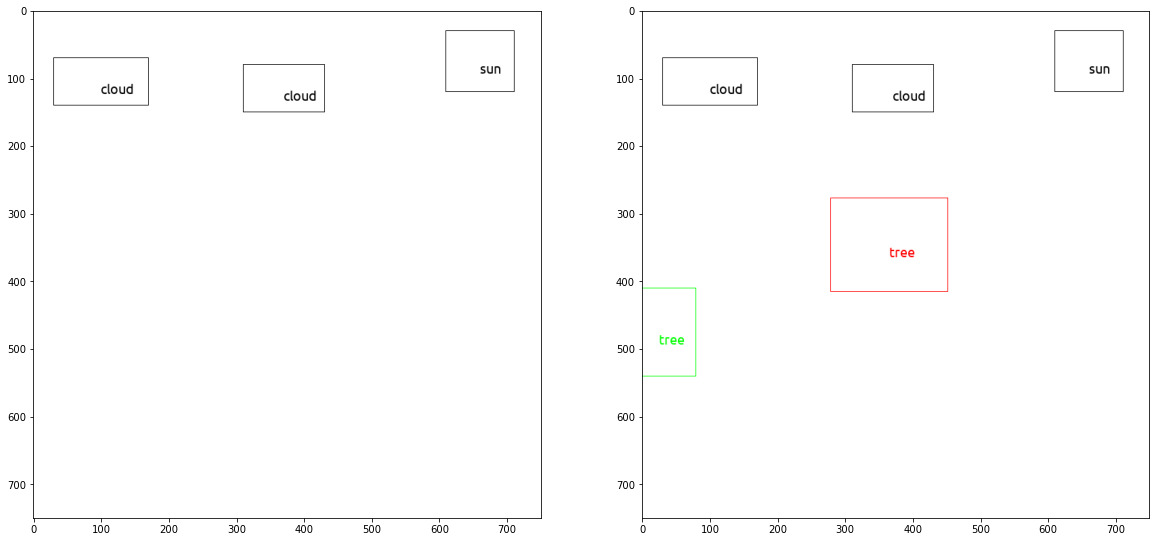

In [12]:
# draw canvas

from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

canvas = Image.new('RGB', (750, 750), (255, 255, 255))

scene_index = 10
pred_index = 3

draw = ImageDraw.Draw(canvas)
r = 5
font = ImageFont.truetype("/usr/share/fonts/truetype/ubuntu/Ubuntu-R.ttf", size=20)

for i in range(pred_index):
    label = class_names[int(y_test[scene_index, i])]
    x, y, w, h = x_test[scene_index, i, -4:] * 750
    x0, y0, x1, y1 = from_yolo(x, y, w, h)
    draw.rectangle((x0, y0, x1, y1), outline=(0, 0, 0))
    draw.text((x, y), label, fill='black', font=font)

# predict
c_out, p_out, _ = interactive_sketcher(
    x_test[scene_index, :pred_index], training=False, look_ahead_mask=None)

c_pred = c_out[0, -1, :]  # 最後のスケッチを取得
c_pred_id = tf.argmax(c_pred, axis=-1)
x, y, w, h = p_out[0, -1, :] * 750  # 最後のスケッチを取得
x0, y0, x1, y1 = from_yolo(x, y, w, h)

next_canvas = canvas.copy()
next_draw = ImageDraw.Draw(next_canvas)
next_draw.rectangle((x0, y0, x1, y1), outline=(255, 0, 0))
next_draw.text((x, y), class_names[c_pred_id], fill=(255, 0, 0), font=font)

# actual
xp, yp, wp, hp = x_test[scene_index, pred_index, -4:] * 750
x0p, y0p, x1p, y1p = from_yolo(xp, yp, wp, hp)
next_draw.rectangle((x0p, y0p, x1p, y1p), outline=(0, 255, 0))
next_draw.text((xp, yp), class_names[int(y_test[scene_index, pred_index])], fill=(0, 255, 0), font=font)

# canvas.save(f'../outputs/canvas_{scene_index}_{pred_index}.png')
# next_canvas.save(f'../outputs/next_canvas_{scene_index}_{pred_index}.png')
plt.figure(figsize=(20, 20))
plt.subplot(121).imshow(canvas)
plt.subplot(122).imshow(next_canvas)